# Pylops - Deghosting with cupy

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import cupy as cp
import scipy as sp
import cusignal
import matplotlib.pyplot as plt

from scipy.signal import convolve, filtfilt
#from scipy.sparse.linalg import inv, lsqr
from scipy.sparse import rand

from pylops import LinearOperator
from pylops.utils import dottest
from pylops.utils.seismicevents import *
from pylops.utils.wavelets import *
from pylops.utils.tapers import *
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.oneway import *
from pylops.optimization.basic import cgls

np.random.seed(10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Phase Shift

In [11]:
#2D
par = {'ox':-300, 'dx':20, 'nx':31,
       'oy':-200, 'dy':20, 'ny':21,
       'ot':0, 'dt':0.004, 'nt':201,
       'f0': 20, 'nfmax': 210}

# Create axis
t, t2, x, y = makeaxis(par)

# Create wavelet
wav = ricker(np.arange(41) * par['dt'], f0=par['f0'])[0]

vrms = [900, 1300, 1800]
t0 = [0.2, 0.3, 0.6]
amp = [1., 0.6, -2.]

_, m = hyperbolic2d(x, t, t0, vrms, amp, wav)

pad = 11
taper = taper2d(par['nt'], par['nx'], 5)
mpad = np.pad(m*taper, ((pad, pad), (0, 0)), mode='constant')

float64


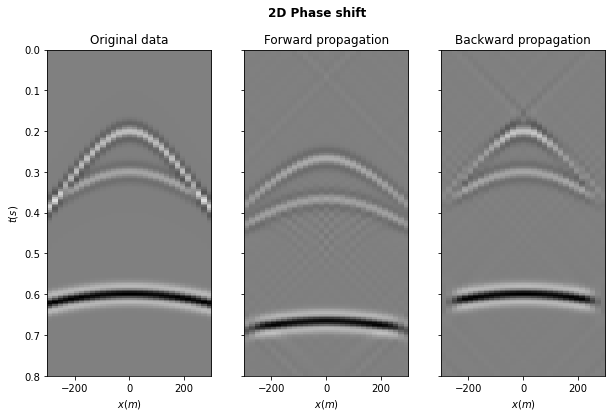

In [12]:
vel = 1500.
zprop = 100
freq = np.fft.rfftfreq(par['nt'], par['dt'])
kx = np.fft.fftshift(np.fft.fftfreq(par['nx'] + 2*pad, par['dx']))
Pop = PhaseShift(vel, zprop, par['nt'], freq, kx)
print(Pop.dtype)
mdown = Pop * cp.asarray(mpad).T.ravel()
mup = Pop.H * mdown.ravel()

mdown = np.real(mdown.reshape(par['nt'], par['nx'] + 2*pad)[:, pad:-pad])
mup = np.real(mup.reshape(par['nt'], par['nx'] + 2*pad)[:, pad:-pad])

fig, axs = plt.subplots(1, 3, figsize=(10, 6), sharey=True)
fig.suptitle('2D Phase shift', fontsize=12,
             fontweight='bold')
axs[0].imshow(m.T, aspect='auto',
              interpolation='nearest', vmin=-2, vmax=2,
              cmap='gray', extent=(x.min(), x.max(), t.max(), t.min()))
axs[0].set_xlabel(r'$x(m)$')
axs[0].set_ylabel(r'$t(s)$')
axs[0].set_title('Original data')
axs[1].imshow(cp.asnumpy(mdown), aspect='auto',
              interpolation='nearest', vmin=-2, vmax=2,
              cmap='gray', extent=(x.min(), x.max(), t.max(), t.min()))
axs[1].set_xlabel(r'$x(m)$')
axs[1].set_title('Forward propagation')
axs[2].imshow(cp.asnumpy(mup), aspect='auto',
              interpolation='nearest', vmin=-2, vmax=2,
              cmap='gray', extent=(x.min(), x.max(), t.max(), t.min()))
axs[2].set_xlabel(r'$x(m)$')
axs[2].set_title('Backward propagation');

float64


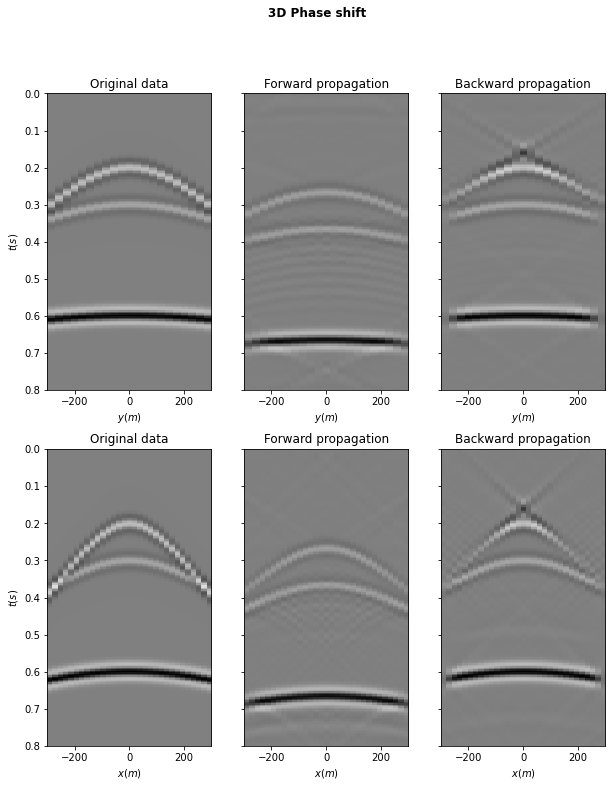

In [13]:
# 3D
_, m = hyperbolic3d(x, y, t, t0, vrms, vrms, amp, wav)

pad = 11
taper = taper3d(par['nt'], (par['ny'], par['nx']), (3, 3))
mpad = np.pad(m*taper, ((pad, pad), (pad, pad), (0, 0)), mode='constant')

kx = np.fft.fftshift(np.fft.fftfreq(par['nx'] + 2*pad, par['dx']))
ky = np.fft.fftshift(np.fft.fftfreq(par['ny'] + 2*pad, par['dy']))
Pop = PhaseShift(vel, zprop, par['nt'], freq, kx, ky)
print(Pop.dtype)

mdown = Pop * cp.asarray(mpad).transpose(2, 1, 0).ravel()

mup = Pop.H * mdown.ravel()

mdown = np.real(mdown.reshape(par['nt'],
                              par['nx'] + 2 * pad,
                              par['ny'] + 2 * pad)[:, pad:-pad, pad:-pad])
mup = np.real(mup.reshape(par['nt'],
                          par['nx'] + 2 * pad,
                          par['ny'] + 2 * pad)[:, pad:-pad, pad:-pad])

fig, axs = plt.subplots(2, 3, figsize=(10, 12), sharey=True)
fig.suptitle('3D Phase shift', fontsize=12,
             fontweight='bold')
axs[0][0].imshow(m[:, par['nx']//2].T, aspect='auto',
              interpolation='nearest', vmin=-2, vmax=2,
              cmap='gray', extent=(x.min(), x.max(), t.max(), t.min()))
axs[0][0].set_xlabel(r'$y(m)$')
axs[0][0].set_ylabel(r'$t(s)$')
axs[0][0].set_title('Original data')
axs[0][1].imshow(cp.asnumpy(mdown)[:, par['nx']//2], aspect='auto',
              interpolation='nearest', vmin=-2, vmax=2,
              cmap='gray', extent=(x.min(), x.max(), t.max(), t.min()))
axs[0][1].set_xlabel(r'$y(m)$')
axs[0][1].set_title('Forward propagation')
axs[0][2].imshow(cp.asnumpy(mup)[:, par['nx']//2], aspect='auto',
              interpolation='nearest', vmin=-2, vmax=2,
              cmap='gray', extent=(x.min(), x.max(), t.max(), t.min()))
axs[0][2].set_xlabel(r'$y(m)$')
axs[0][2].set_title('Backward propagation')
axs[1][0].imshow(m[par['ny'] // 2].T, aspect='auto',
                 interpolation='nearest', vmin=-2, vmax=2,
                 cmap='gray', extent=(x.min(), x.max(), t.max(), t.min()))
axs[1][0].set_xlabel(r'$x(m)$')
axs[1][0].set_ylabel(r'$t(s)$')
axs[1][0].set_title('Original data')
axs[1][1].imshow(cp.asnumpy(mdown)[:, :, par['ny'] // 2], aspect='auto',
                 interpolation='nearest', vmin=-2, vmax=2,
                 cmap='gray', extent=(x.min(), x.max(), t.max(), t.min()))
axs[1][1].set_xlabel(r'$x(m)$')
axs[1][1].set_title('Forward propagation')
axs[1][2].imshow(cp.asnumpy(mup)[:, :, par['ny'] // 2], aspect='auto',
                 interpolation='nearest', vmin=-2, vmax=2,
                 cmap='gray', extent=(x.min(), x.max(), t.max(), t.min()))
axs[1][2].set_xlabel(r'$x(m)$')
axs[1][2].set_title('Backward propagation');

## Deghosting

In [14]:
inputfile = '../data/updown/input.npz'

/tmp/ipykernel_21693/1650403688.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iwin = np.round(direct_off/dt).astype(np.int)


CGLS
-----------------------------------------------------------------
The Operator Op has 217281 rows and 217281 cols
damp = 1.000000e-20	tol = 1.000000e-04	niter = 60
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        0.0000e+00         2.4360e+00     2.4360e+00
     2        3.6363e-05         1.1917e+00     1.1917e+00
     3        7.5131e-05         8.2792e-01     8.2792e-01
     4        8.2066e-05         6.3655e-01     6.3655e-01
     5        7.0120e-05         5.1191e-01     5.1191e-01
     6        9.3156e-06         4.2773e-01     4.2773e-01
     7       -1.3079e-04         3.6816e-01     3.6816e-01
     8       -3.0993e-04         3.2454e-01     3.2454e-01
     9       -4.6907e-04         2.9121e-01     2.9121e-01
    10       -5.6001e-04         2.6573e-01     2.6573e-01
    11       -5.8831e-04         2.4584e-01     2.4584e-01
    21       -8.9361e-04         1.4366e-01     1.4366e-01

(1.0, 0.0)

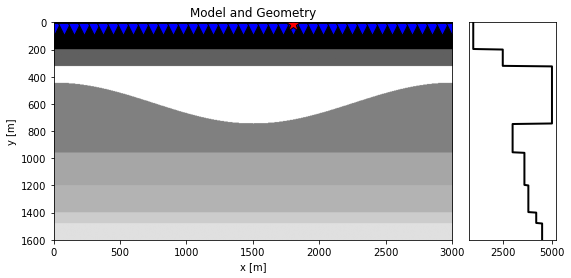

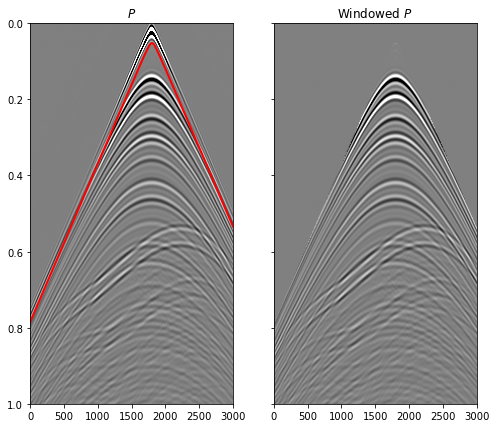

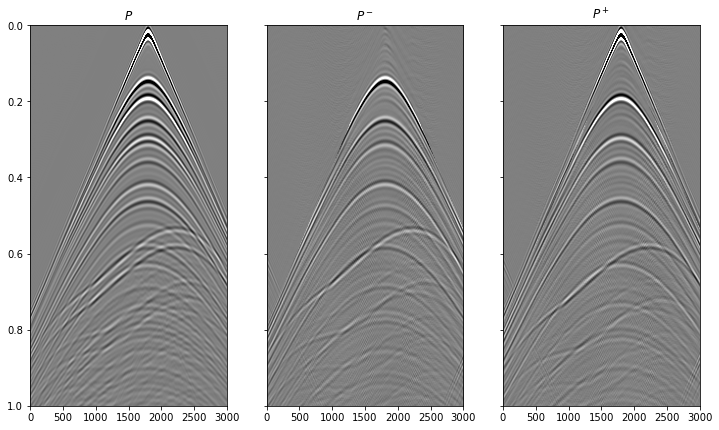

In [15]:
inputdata = np.load(inputfile)

vel_sep = 2400.0 # velocity at separation level
clip = 1e-1 # plotting clip

# Receivers
r = inputdata['r']
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]

# Sources
s = inputdata['s']

# Model
rho = inputdata['rho']

# Axes
t = inputdata['t']
nt, dt = len(t), t[1]-t[0]
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

# Data
p = inputdata['p'].T
p /= p.max()

fig = plt.figure(figsize=(9, 4))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=4)
ax2 = plt.subplot2grid((1, 5), (0, 4))
ax1.imshow(rho, cmap='gray', extent=(x[0], x[-1], z[-1], z[0]))
ax1.scatter(r[0, ::5], r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
ax1.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
ax1.axis('tight')
ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
ax1.set_title('Model and Geometry')
ax1.set_xlim(x[0], x[-1])
ax1.set_ylim(z[-1], z[0])
ax2.plot(rho[:, len(x)//2], z, 'k', lw=2)
ax2.set_ylim(z[-1], z[0])
ax2.set_yticks([], [])

# 2D Deghosting
direct = np.sqrt(np.sum((s[:, np.newaxis]-r)**2, axis=0))/vel_sep

# Window
off = 0.035
direct_off = direct + off
win = np.zeros((nt, nr))
iwin = np.round(direct_off/dt).astype(np.int)
for i in range(nr):
    win[iwin[i]:, i] = 1


fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 7))
axs[0].imshow(p.T, cmap='gray', vmin=-clip*np.abs(p).max(),
              vmax=clip*np.abs(p).max(),
              extent=(r[0, 0], r[0, -1], t[-1], t[0]))
axs[0].plot(r[0], direct_off, 'r', lw=2)
axs[0].set_title(r'$P$')
axs[0].axis('tight')
axs[1].imshow(win * p.T, cmap='gray', vmin=-clip*np.abs(p).max(),
              vmax=clip*np.abs(p).max(),
              extent=(r[0, 0], r[0, -1], t[-1], t[0]))
axs[1].set_title(r'Windowed $P$')
axs[1].axis('tight')
axs[1].set_ylim(1, 0)

###############################################################################
# We can now perform deghosting

p = cp.asarray(p)
pup, pdown = Deghosting(p.T, nt, nr, dt, dr, vel_sep,
                        r[1, 0] + dz, win=cp.asarray(win),
                        npad=5, ntaper=11, solver=cgls,
                        dottest=False, dtype='complex128',
                        **dict(x0=cp.zeros_like(p).ravel(), damp=1e-10, 
                               niter=60, show=2))

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 7))
axs[0].imshow(cp.asnumpy(p).T, cmap='gray', vmin=-clip * np.abs(p).max(),
              vmax=clip * np.abs(p).max(),
              extent=(r[0, 0], r[0, -1], t[-1], t[0]))
axs[0].set_title(r'$P$')
axs[0].axis('tight')
axs[1].imshow(cp.asnumpy(pup), cmap='gray', vmin=-clip * np.abs(p).max(),
              vmax=clip * np.abs(p).max(),
              extent=(r[0, 0], r[0, -1], t[-1], t[0]))
axs[1].set_title(r'$P^-$')
axs[1].axis('tight')
axs[2].imshow(cp.asnumpy(pdown), cmap='gray', vmin=-clip * np.abs(p).max(),
              vmax=clip * np.abs(p).max(),
              extent=(r[0, 0], r[0, -1], t[-1], t[0]))
axs[2].set_title(r'$P^+$')
axs[2].axis('tight')
axs[2].set_ylim(1, 0)